# AiiDA-WorkGraph: From Zero To Hero

## Introduction
In this tutorial, you will learn `AiiDA-WorkGraph` to build your workflow to carry out DFT calculation. It's recommended to run this tutorial inside a Jupyter notebook.

## Requirements
To run this tutorial, you need to install `aiida-workgraph`, `aiida-quantumespresso`. Open a terminal and run:

```console
pip install aiida-workgraph aiida-quantumespresso
```

Restart (or start) the AiiDA daemon if needed:

```console
verdi daemon restart
```

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.

In AiiDA, we can define two `calcfunction` to do the `add` and `mutiply`:

In [2]:
from aiida.engine import calcfunction

@calcfunction
def add(x, y):
    return x + y

@calcfunction
def multiply(x, y):
    return x * y


### Create the workflow
Three steps:

- create a empty `WorkGraph`
- add tasks: `add` and `multiply`.
- link the output of the `add` task to the `x` input of the `multiply` task.


In a jupyter notebook, you can visualize the workgraph directly.

In [3]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("add_multiply_workflow")
wg.tasks.new(add, name="add1")
wg.tasks.new(multiply, name="multiply1", x = wg.tasks["add1"].outputs["result"])
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg

One can compare it with the `WorkChain` version by expanding the following details:

<details>
<summary>Compare to the `WorkChain` Version</summary>


```python
from aiida.engine import WorkChain

class AddMultiplyWorkChain(WorkChain):

    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input('x')
        spec.input('y')
        spec.input('z')
        spec.outline(
            cls.add,
            cls.multiply,
            cls.results,
        )

     def add(self):
        self.ctx.sum = add(self.inputs.x, self.inputs.y)

    def multiply(self):
        self.ctx.product = multiply(self.ctx.sum, self.inputs.z)

    def results(self):
        self.out('result', self.ctx.product)
```
</details>

### Submit the workgraph

WorkGraph process created, PK: 22112

Result of multiply1 is uuid: 1f89839f-4f4d-4001-aa0e-7e73d87a175e (pk: 22116) value: 20 




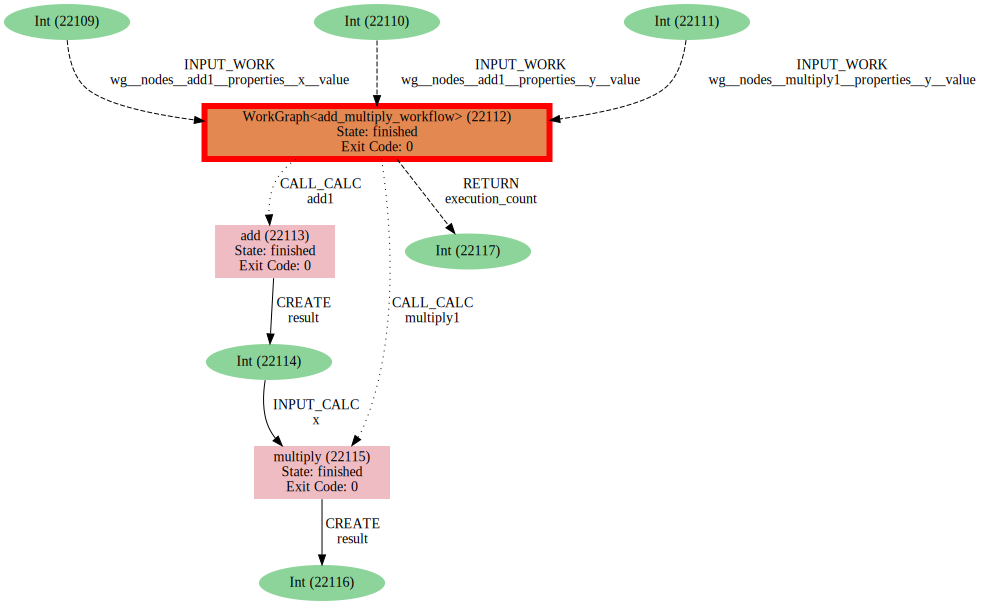

In [4]:
from aiida_workgraph.utils import generate_node_graph
from aiida.orm import Int

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add1": {"x": Int(2),
                             "y": Int(3)},
                    "multiply1": {"y": Int(4)}
                    },
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply1 is {} \n\n".format(wg.tasks["multiply1"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## CalcJob and WorkChain
AiiDA uses `CalcJob` to run a calculation on a remote computer. AiiDA community also provides a lot of well-written `calcfunction` and `WorkChain`. One can use these AiiDA component direclty in the WorkGraph. The inputs and outputs of the task is automatically generated based on the input and output port of the AiiDA component.

Here is an example of using the `ArithmeticAddCalculation` Calcjob inside the workgraph. Suppose we want to calculate ```(x + y) + z ``` in two steps.

In [5]:
from aiida_workgraph import WorkGraph
from aiida.calculations.arithmetic.add import ArithmeticAddCalculation

wg = WorkGraph("test_calcjob")
new = wg.tasks.new
new(ArithmeticAddCalculation, name="add1")
wg.tasks.new(ArithmeticAddCalculation, name="add2", x=wg.tasks["add1"].outputs["sum"])
wg.to_html()

#### Inspect the node
How do I know which input and output to connect?

The inputs and outputs of a task are generated automatically based on the inputs/outputs of the AiiDA component. WorkGraph also has some built-in ports, like `_wait` and `_outputs`.  One can inpsect a task's inputs and outputs.

Note: special case for `calcfunction`, the default name of its output is `result`.

In [6]:
# visualize the task
wg.tasks["add1"].to_html()

## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.



### Define a workgraph
aiida-quantumespresso provides `PwCalculation` CalcJob and `PwBaseWorkChain` to run a PW calculation. we can use it directly in the WorkGraph. Here we use the `PwCalculation` CalcJob.

In [7]:
from aiida_workgraph import WorkGraph
from aiida.engine import calcfunction
from aiida_quantumespresso.calculations.pw import PwCalculation


@calcfunction
def atomization_energy(output_atom, output_mol):
    from aiida.orm import Float
    e = output_atom["energy"]*output_mol["number_of_atoms"] - output_mol["energy"]
    return Float(e)

wg = WorkGraph("atomization_energy")
pw_atom = wg.tasks.new(PwCalculation, name="pw_atom")
pw_mol = wg.tasks.new(PwCalculation, name="pw_mol")
# create the task to calculate the atomization energy
wg.tasks.new(atomization_energy, name="atomization_energy",
             output_atom=pw_atom.outputs["output_parameters"],
             output_mol=pw_mol.outputs["output_parameters"])
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg

### Prepare the inputs and submit the workflow
You need to set up the code, computer, and pseudo potential for the calculation. Please refer to the this [documentation](https://aiida-quantumespresso.readthedocs.io/en/latest/installation/index.html) for more details.

You can also stip this step.

In [8]:
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group
from ase.build import molecule
from ase import Atoms

load_profile()
# create structure
n_atom = Atoms("N")
n_atom.center(vacuum=1.5)
n_atom.pbc = True
structure_n = StructureData(ase=n_atom)
structure_n2 = StructureData(ase=molecule("N2", vacuum=1.5, pbc=True))
# create the PW task
code = load_code("qe-7.2-pw@localhost")
paras = Dict({
        "CONTROL": {
            "calculation": "scf",
        },
        "SYSTEM": {
            "ecutwfc": 30,
            "ecutrho": 240,
            "occupations": "smearing",
            "smearing": "gaussian",
            "degauss": 0.1,
        },
    })
kpoints = KpointsData()
kpoints.set_kpoints_mesh([1, 1, 1])
# Load the pseudopotential family.
pseudo_family = load_group('SSSP/1.3/PBEsol/efficiency')
pseudos = pseudo_family.get_pseudos(structure=structure_n2)
#
metadata = {
    'options': {'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 1,
            },
        }
    }

#------------------------- Set the inputs -------------------------
wg.tasks["pw_atom"].set({"code": code,
         "structure": structure_n,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata
        })
wg.tasks["pw_mol"].set({"code": code,
         "structure": structure_n2,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata
        })
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.tasks['pw_atom'].outputs["output_parameters"].value.get_dict()["energy"]))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.tasks['pw_mol'].outputs["output_parameters"].value.get_dict()["energy"]))
print('Atomization energy:                  {:0.3f} eV'.format(wg.tasks['atomization_energy'].outputs["result"].value.value))


WorkGraph process created, PK: 22122
Energy of a N atom:                  -266.359
Energy of an un-relaxed N2 molecule: -547.169
Atomization energy:                  14.451 eV


Generate node graph from the AiiDA process:

/home/wang_x3/apps/miniconda3/envs/aiida/lib/python3.10/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


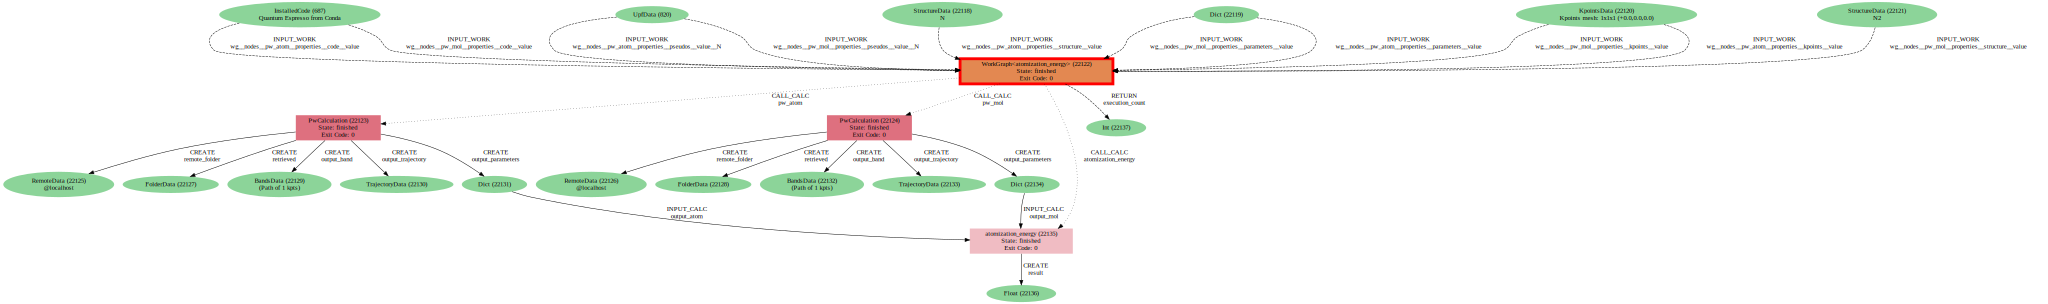

In [9]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Advanced Topic: Dynamic Workgraph

### Graph builder
If we want to generate the workgraph on-the-fly, for example, if you want to use `if` and `for` to create the tasks, or repeat a calculation until it converges, you can use Graph Builder.

Suppose we want to calculate:
```python
# step 1
result = add(x, y)
# step 2
if result > 0:
    result = add(result, y)
else:
    result = multiply(result, y)
# step 3
result = add(result, y)
```


In [10]:
# Create a WorkGraph which is dynamically generated based on the input
# then we output the result of from the context (context)
from aiida_workgraph import task

@task.graph_builder(outputs = [["context.result", "result"]])
def add_multiply_if_generator(x, y):
    wg = WorkGraph()
    if x.value > 0:
        add1 = wg.tasks.new(add, name="add1", x=x, y=y)
        # export the result of add1 to the context, so that context.result = add1.results
        add1.to_context = [["result", "result"]]
    else:
        multiply1 = wg.tasks.new(multiply, name="multiply1", x=x, y=y)
        # export the result of multiply1 to the context
        multiply1.to_context = [["result", "result"]]
    return wg

wg = WorkGraph("if_task")
wg.tasks.new(add, name="add1")
wg.tasks.new(add_multiply_if_generator, name="add_multiply_if1", x = wg.tasks["add1"].outputs["result"])
wg.tasks.new(add, name="add2", x = wg.tasks["add_multiply_if1"].outputs["result"])
wg.to_html()


In [11]:
wg.submit(inputs = {"add1": {"x": 1, "y": 2},
                    "add_multiply_if1": {"y": 2},
                    "add2": {"y": 2},
                   },
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of add2 is {} \n\n".format(wg.tasks["add2"].outputs['result'].value))

WorkGraph process created, PK: 22138

Result of add2 is uuid: 7ddb402f-b29c-4895-a554-ff8d91439691 (pk: 22150) value: 7 




Note: one can not see the detail of the `add_multiply_if1` before you running it.

## Second Real-world Workflow: Equation of state (EOS) WorkGraph

First, create the calcfunction for the job.

In [12]:
from aiida import orm
from aiida_workgraph import task

# explicitly define the output socket name to match the return value of the function
@task.calcfunction(outputs=[["General", "structures"]])
def scale_structure(structure, scales):
    """Scale the structure by the given scales."""
    atoms = structure.get_ase()
    structures = {}
    for i in range(len(scales)):
        atoms1 = atoms.copy()
        atoms1.set_cell(atoms.cell * scales[i], scale_atoms=True)
        structure = orm.StructureData(ase=atoms1)
        structures[f"s_{i}"] = structure
    return {"structures": structures}

# Output result from context to the output socket
@task.graph_builder(outputs=[["context.result", "result"]])
def all_scf(structures, scf_inputs):
    """Run the scf calculation for each structure."""
    from aiida_workgraph import WorkGraph
    from aiida_quantumespresso.calculations.pw import PwCalculation
    wg = WorkGraph()
    for key, structure in structures.items():
        pw1 = wg.tasks.new(PwCalculation, name=f"pw1_{key}", structure=structure)
        pw1.set(scf_inputs)
        # save the output parameters to the context
        pw1.to_context = [["output_parameters", f"result.{key}"]]
    return wg


@task.calcfunction()
# because this is a calcfunction, and the input datas are dynamic, we need use **datas.
def eos(**datas):
    """Fit the EOS of the data."""
    from ase.eos import EquationOfState

    volumes = []
    energies = []
    for _, data in datas.items():
        volumes.append(data.dict.volume)
        energies.append(data.dict.energy)
        unit = data.dict.energy_units
    #
    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    eos = orm.Dict({"unit": unit, "v0": v0, "e0": e0, "B": B})
    return eos

### Define the WorkGraph:

In [13]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("eos")
scale_structure1 = wg.tasks.new(scale_structure, name="scale_structure1")
all_scf1 = wg.tasks.new(all_scf, name="all_scf1", structures=scale_structure1.outputs["structures"])
eos1 = wg.tasks.new(eos, name="eos1", datas=all_scf1.outputs["result"])
wg.to_html()

### Combine with a relax task

In [14]:
from aiida_workgraph import WorkGraph, task
from aiida_quantumespresso.calculations.pw import PwCalculation

@task.graph_builder(outputs=[["eos1.result", "result"]])
def eos_workgraph(structure=None, scales=None, scf_inputs=None):
    wg = WorkGraph("eos")
    scale_structure1 = wg.tasks.new(scale_structure, name="scale_structure1", structure=structure, scales=scales)
    all_scf1 = wg.tasks.new(all_scf, name="all_scf1", scf_inputs=scf_inputs)
    eos1 = wg.tasks.new(eos, name="eos1")
    wg.links.new(scale_structure1.outputs["structures"], all_scf1.inputs["structures"])
    wg.links.new(all_scf1.outputs["result"], eos1.inputs["datas"])
    return wg


#-------------------------------------------------------
wg = WorkGraph("relax_eos")
relax_task = wg.tasks.new(PwCalculation, name="relax1")
eos_wg_task = wg.tasks.new(eos_workgraph, name="eos1", structure=relax_task.outputs["output_structure"])
wg.to_html()

### Useful tool: Web GUI
Open a terminal, and run:
```
workgraph web start
```
Then visit the page http://127.0.0.1:8000/workgraph, you can view all the workgraphs here.

## What's Next

|        |                                         |
|---------------|----------------------------------------------------|
| [Concepts](https://aiida-workgraph.readthedocs.io/en/latest/concept/index.html)                          | A brief introduction of WorkGraph’s main concepts.  |
| [Tutorials](https://aiida-workgraph.readthedocs.io/en/latest/tutorial/index.html)                        | Real-world examples in computational materials science and more.                     |
| [HowTo](https://aiida-workgraph.readthedocs.io/en/latest/howto/index.html)                              | Advanced topics and tips, e.g flow control using `if`, `for`, `while` and `context`.    |



